In [68]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import uncrater as uc
from uncrater.utils import cordic2rad, rad2cordic, cordic_add

alpha_to_pdrift = 50e3*4096*16/102.4e6*2*np.pi*1e-6


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import json
def read_adc(ch):
    jdata = json.load(open(f'/u/home/anze/Nov21/adc{ch}_output.json'))
    data = np.array(jdata['data'])
    data[data>8192]-=16384
    return data

ewf = [read_adc(ch+1) for ch in range(4)]

def spec(w):
    return np.abs(np.fft.rfft(w)**2)

In [75]:
C = uc.Collection("session_calibrator/cdi_output", cut_to_hello=True,verbose=True)
#C.spectra[0]['meta'].base.actual_gain[:], C.spectra[0]['meta'].adc_min, C.calib_gNacc

Analyzing 46 files from session_calibrator/cdi_output.
Reading  session_calibrator/cdi_output/00000_0209.bin
Reading  session_calibrator/cdi_output/00001_0206.bin
Reading  session_calibrator/cdi_output/00002_020a.bin
Reading  session_calibrator/cdi_output/00003_020a.bin
Reading  session_calibrator/cdi_output/00004_020a.bin
Reading  session_calibrator/cdi_output/00005_020a.bin
Reading  session_calibrator/cdi_output/00006_028c.bin
x 10172 652
Reading  session_calibrator/cdi_output/00007_028d.bin
x 12288 653
Reading  session_calibrator/cdi_output/00008_028e.bin
x 12288 654
Reading  session_calibrator/cdi_output/00009_028f.bin
x 12288 655
Reading  session_calibrator/cdi_output/00010_0290.bin
x 12268 656
Reading  session_calibrator/cdi_output/00011_0291.bin
x 12288 657
Reading  session_calibrator/cdi_output/00012_0292.bin
x 148 658
Reading  session_calibrator/cdi_output/00013_0293.bin
x 12288 659
Reading  session_calibrator/cdi_output/00014_020a.bin
Reading  session_calibrator/cdi_output/00

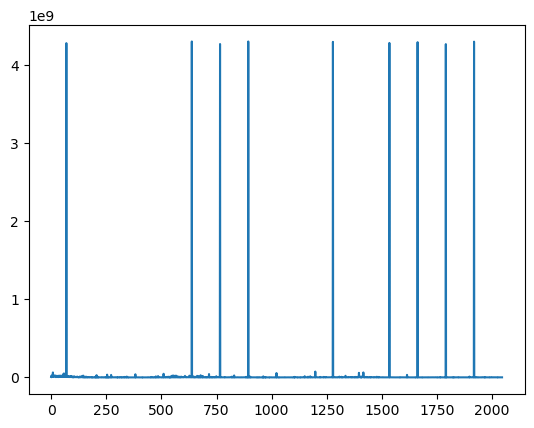

In [76]:
plt.plot(C.spectra[0][1].data[2:])


In [77]:
import binascii
weights = np.zeros(512)
weights[299:500] = 1.0
intweights = (weights*255).astype(np.uint32)
#intweights[(intweights == 0xFF)] = 0x100
pweights = [((w2<<16)+w1) for w1,w2 in zip(intweights[0::2],intweights[1::2])]
print ("CRC32 weights: ", hex(binascii.crc32(np.array(pweights,dtype=np.uint32).tobytes())&0xffffffff))


hex(C.cont[1].crc), C.cont[1].weight_ndx

CRC32 weights:  0xdd3fb62


('0xdd3fb62', 0)

Text(0.5, 0.98, 'PTOPBOT')

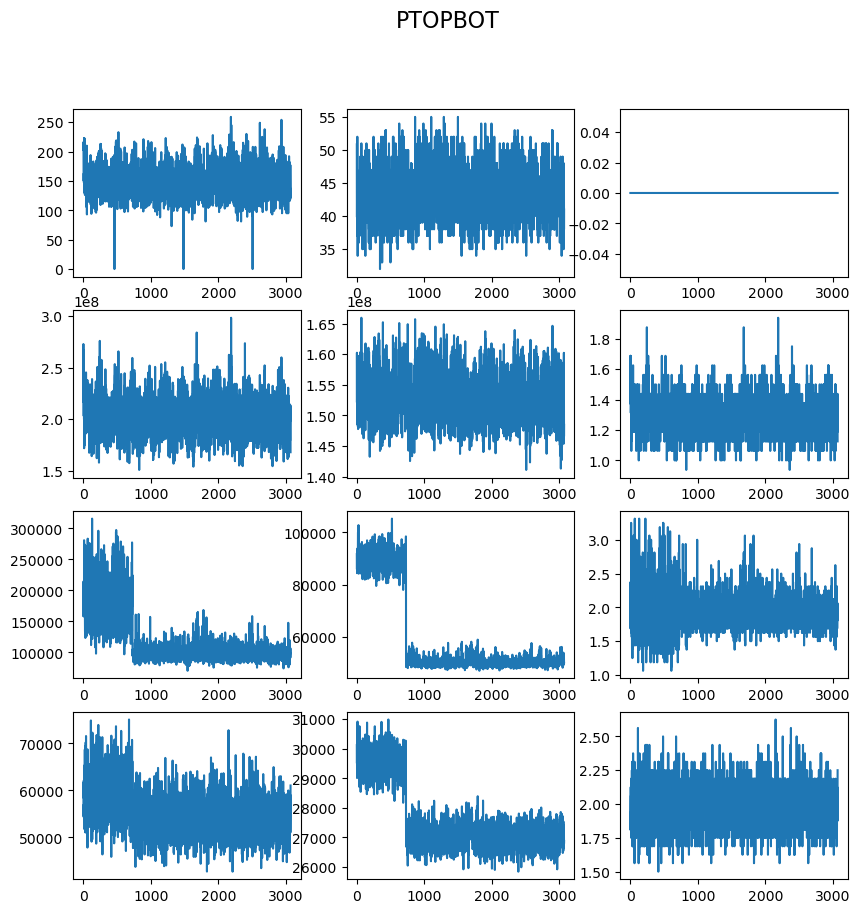

In [78]:
fig, ax = plt.subplots(4,3,figsize=(10,10))
ax[0,0].plot(C.cd_powertop0)
ax[1,0].plot(C.cd_powertop1)
ax[2,0].plot(C.cd_powertop2)
ax[3,0].plot(C.cd_powertop3)

ax[0,1].plot(C.cd_powerbot0)
ax[1,1].plot(C.cd_powerbot1)
ax[2,1].plot(C.cd_powerbot2)
ax[3,1].plot(C.cd_powerbot3)

ax[0,2].plot(C.cd_snr0)
ax[1,2].plot(C.cd_snr1)
ax[2,2].plot(C.cd_snr2)
ax[3,2].plot(C.cd_snr3)
fig.suptitle('PTOPBOT', fontsize=16)

In [64]:
plt.figure(figsize=(10, 6))
freq = C.spectra[2]['meta'].frequency
plt.plot(freq[100:],C.spectra[3][2].data[100:])
plt.plot(freq[102::4],C.spectra[3][2].data[102::4],'r.')
plt.ylim(500,700)

IndexError: list index out of range

<Figure size 1000x600 with 0 Axes>

np.float64(0.00013636509733754937)

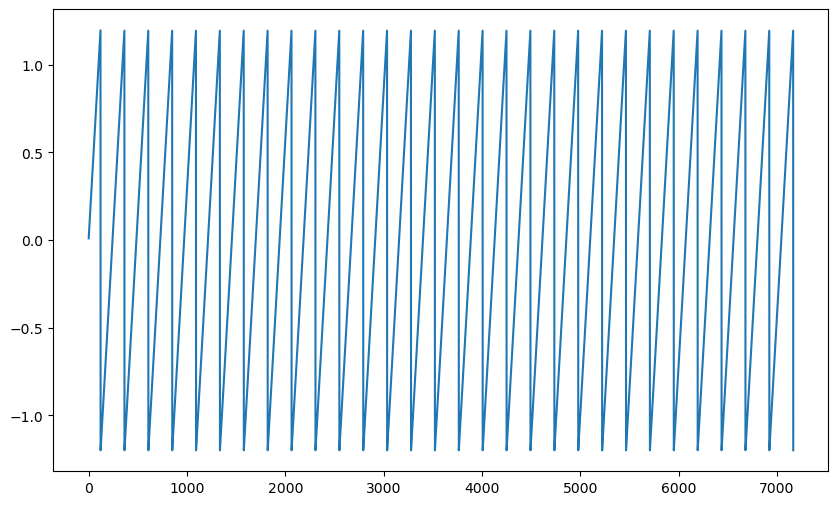

In [65]:

#Cd = uc.Collection("session_calibrator_sd0/cdi_output", cut_to_hello=True)
plt.figure(figsize=(10, 6))
plt.plot(C.cd_drift[::1]/alpha_to_pdrift)
#plt.plot(C.cd_have_lock[:]*0.1,'--')
#plt.plot(np.arange(75), np.arange(75)*0.005)
#plt.plot(C.cd_have_lock[:200]*0.1)
#plt.plot(Cd.cd_drift[:200]/alpha_to_pdrift)
C.cd_drift[200:2000].std()#,Cd.cd_drift[200:2000].std()

/u/home/anze/anaconda3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/u/home/anze/anaconda3/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[]

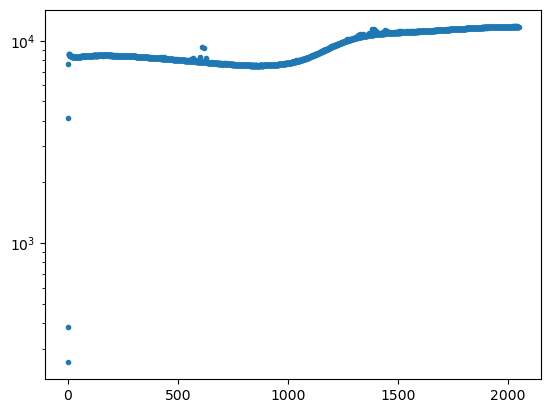

In [9]:
for i in [0,7]:
    plt.plot(np.mean(np.array([sp[2].data[:] for sp in C.spectra[i::8]]),axis=0),'.')
plt.semilogy()

([np.float64(7410.0),
  np.float64(7414.0),
  np.float64(7405.0),
  np.float64(7413.0),
  np.float64(7409.0),
  np.float64(7415.0),
  np.float64(7403.0)],)

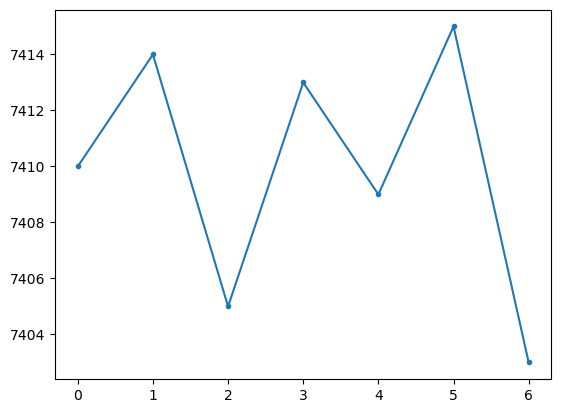

In [290]:
plt.plot([sp[1].data[1201] for sp in C.spectra],'.-')
#plt.plot([sp[2].data[1202] for sp in C.spectra])
#plt.plot([sp[0].data[1203] for sp in C.spectra])

13+(22-13)*25/len(C.spectra)

[sp[1].data[1201] for sp in C.spectra],


Text(0, 0.5, 'Relative drift [ppm]')

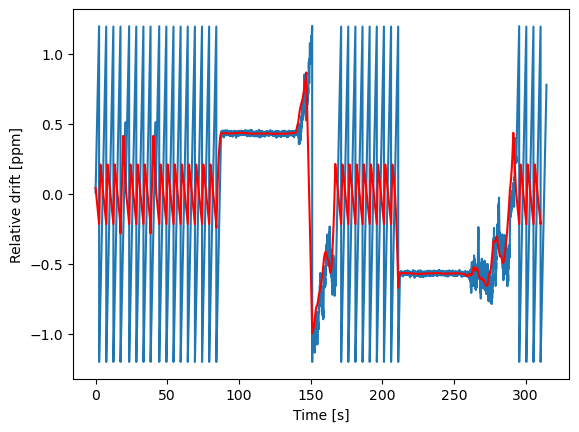

In [291]:
time = np.arange(len(C.cd_drift))*32*16*4096/102.4e6
plt.plot(time,C.cd_drift/alpha_to_pdrift)
avg_drift = np.convolve(C.cd_drift/alpha_to_pdrift, np.ones(200)/200, mode='valid')
avg_time = time[:len(avg_drift)]
plt.plot(avg_time, avg_drift,'r-')
plt.xlabel('Time [s]')  
plt.ylabel('Relative drift [ppm]')
#plt.xlim(0,1)
#plt.plot(Cd.cd_drift[:125]/alpha_to_pdrift)



In [292]:
(C.cd_drift/alpha_to_pdrift)[-5000:].std()/np.sqrt(5000)

np.float64(0.005770609326824042)

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0., 1338.,   18.,   20.,   16.,   28.,   21.,
          16.,   24.,   21.,   30.,   33.,   46.,   44.,   38.,   52.,
          56.,   58.,   66.,   63.,   65.,   84.,   68.,   62.,   79.,
          86.,   97.,   94.,   74.,  113.,  117.,  110.,  111.,  112.,
         113.,  108.,   96.,  119.,  127.,  110.,  121.,  142.,  115.,
         105.,   89.,  133.,  115.,  111.,  117.,   87.,   89.,  100.,
          90.,   95.,   74.,   80., 7308.,   50.,   63.,   57.,   59.,
          61.,   59.,   50.,   53.,   45.,   36.,   31.,   33.,   33.,
          32.,   15.,   26.,   24.,   19.,   15.,   11., 1449.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.]),
 array([-2000.        , -1960.3960396 , -1920.79207921, -1881.18811881,
        -1841.58415842, -1801.98019802, -1762.37623762, -1722.77227723,
        -1683.16831683, -1643.56435644, -1603.96039

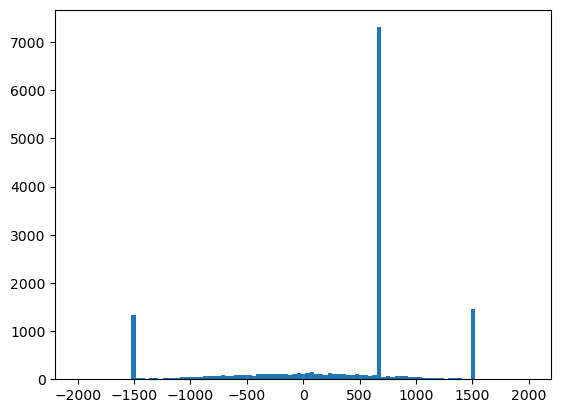

In [293]:
x = C.cd_drift[200:]/np.pi*(1<<30)#/alpha_to_pdrift
d = x[1:]-x[:-1]

plt.hist(d,bins=101,range=(-2000,+2000))
#plt.ylim(0,200)


Text(0.5, 0.98, 'PTOPBOT')

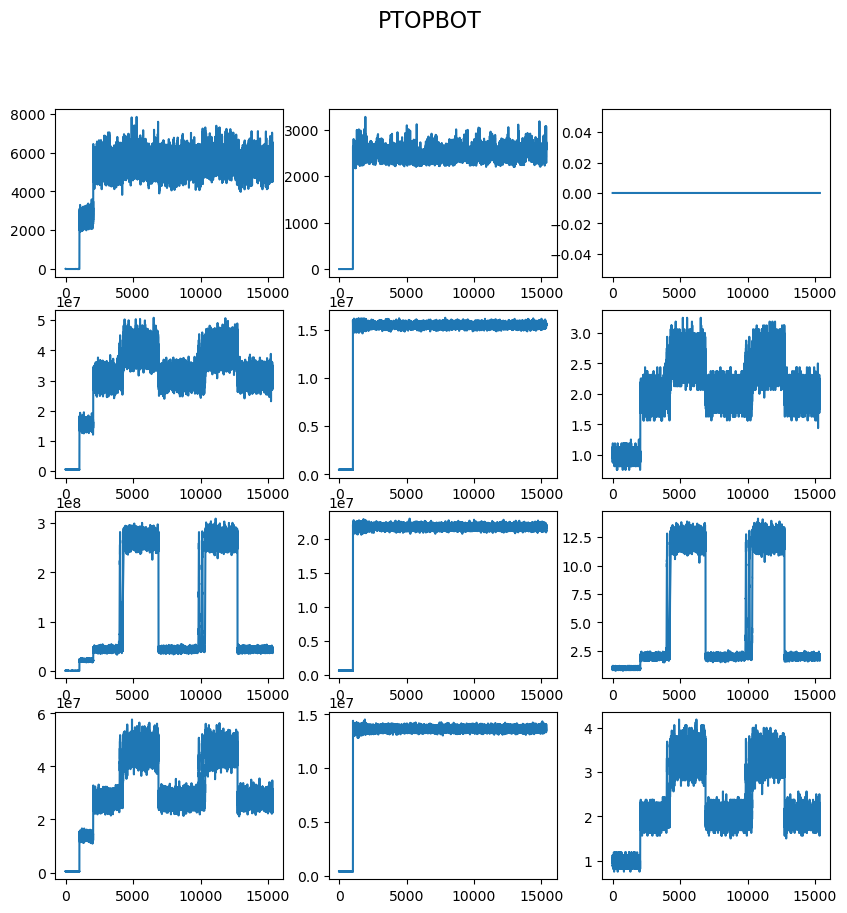

In [294]:
fig, ax = plt.subplots(4,3,figsize=(10,10))
ax[0,0].plot(C.cd_powertop0)
ax[1,0].plot(C.cd_powertop1)
ax[2,0].plot(C.cd_powertop2)
ax[3,0].plot(C.cd_powertop3)

ax[0,1].plot(C.cd_powerbot0)
ax[1,1].plot(C.cd_powerbot1)
ax[2,1].plot(C.cd_powerbot2)
ax[3,1].plot(C.cd_powerbot3)

ax[0,2].plot(C.cd_snr0)
ax[1,2].plot(C.cd_snr1)
ax[2,2].plot(C.cd_snr2)
ax[3,2].plot(C.cd_snr3)
fig.suptitle('PTOPBOT', fontsize=16)


(np.float64(12300948.986442063),
 np.float64(-1556382.0002673797),
 np.float64(31045482.08111979),
 np.float64(14482972.234505208))

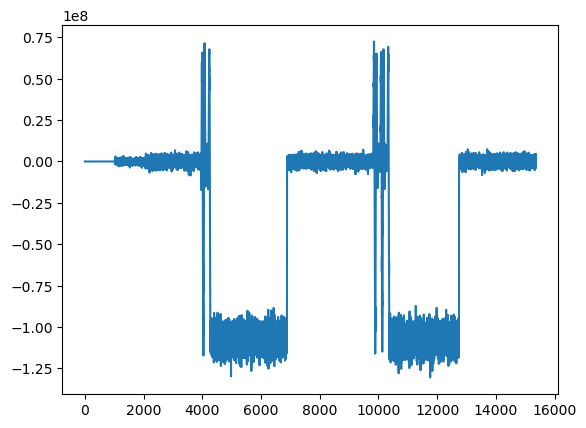

In [295]:
#plt.plot (C.cd_sd2[200:])
plt.plot (C.cd_sd2[:])
C.cd_fd1[400:].std(),C.cd_sd1[400:].mean(), C.cd_powertop1.mean(), C.cd_powerbot1.mean()
#plt.plot (C.cd_snr3[200:])
#plt.plot(C.cd_powerbot3)

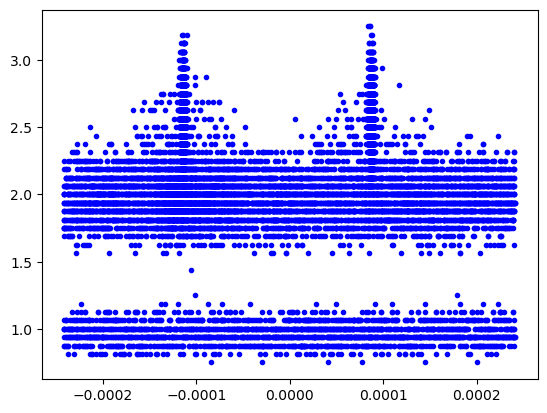

In [296]:
plt.plot(C.cd_drift,C.cd_snr1,'b.')
#C.cd_powerbot2[:4000].std()/C.cd_powerbot2[:4000].mean()
#Cd.cd_powertop2[1000:3000].mean()/C.cd_powertop2[1000:3000].mean()

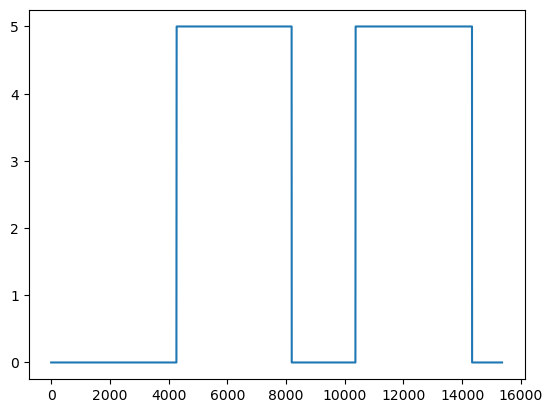

In [297]:
plt.plot(C.cd_have_lock)

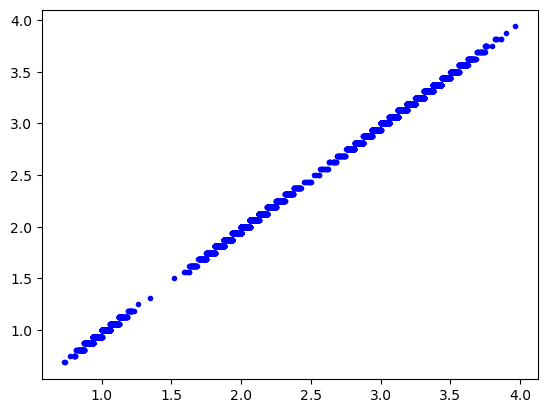

In [235]:
#plt.plot(Cd.cd_snr1[200:])
plt.plot(C.cd_powertop1[200:]/C.cd_powerbot1[200:], C.cd_snr1[200:],'b.')
#plt.plot()


#plt.plot(C.cd_fd2[1200:])
#plt.plot(C.cd_fd3[1200:])


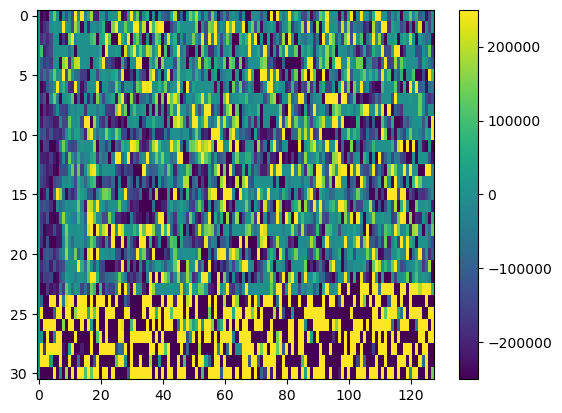

In [236]:
plt.imshow(C.calib_gphase[1:,:128],aspect='auto', interpolation='nearest')#,vmin=-100000, vmax=100000)
plt.colorbar()

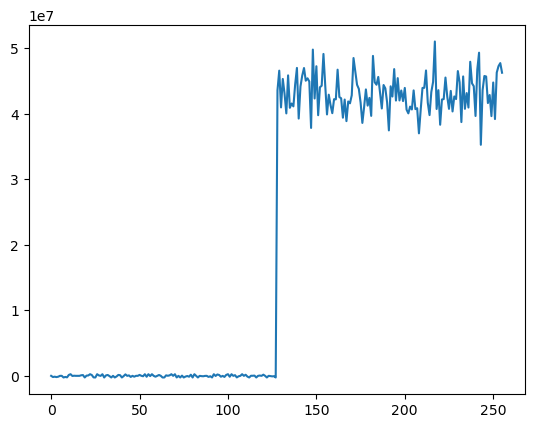

In [237]:
plt.plot(C.calib_gphase[3,:256])

[]

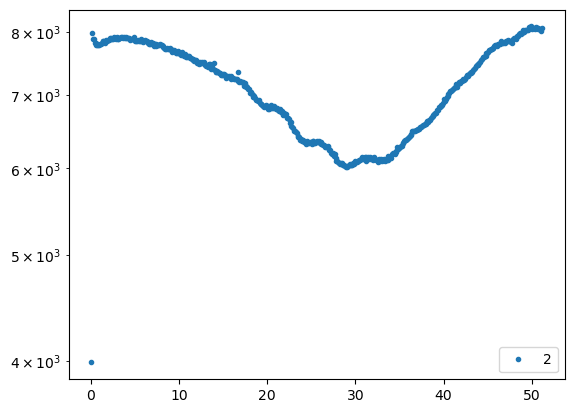

In [193]:
f = C.spectra[0][0].frequency
s0 = C.spectra[0][3].data[:]
s1 = C.spectra[1][3].data[:]
s2 = C.spectra[2][3].data[:]
#plt.plot(f,s2)
for i in [2]:
    plt.plot(f[i::4], s2[i::4],'.', label=str(i))
plt.legend()
#plt.plot(s1,'g.')
#plt.plot(s2,'b.')
#plt.plot(s1*0.001,'r.')

plt.semilogy()

Text(0, 0.5, 'power')

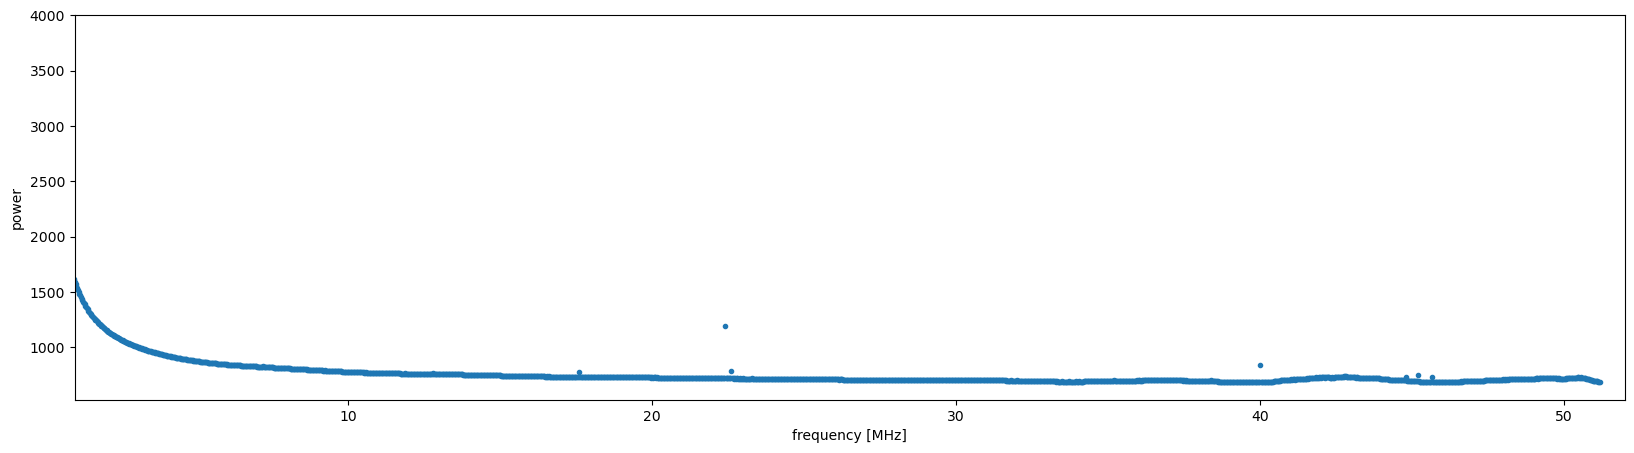

In [194]:

plt.figure(figsize=(20,5))
f = C.spectra[0][0].frequency
for i in [0]:
    s = np.mean([sp[i].data[:] for sp in C.spectra],axis=0)
    plt.plot(f[10:],s[10:],'.')

#plt.plot(f[2::4],s[2::4],'r.',markersize=3)
plt.xlim(1,52)
#plt.ylim(0,1e4)
#plt.ylim(3.0e6,5e6)
#plt.ylim(0.1e3,2e6)
#plt.ylim(3e6,2e7)
#plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

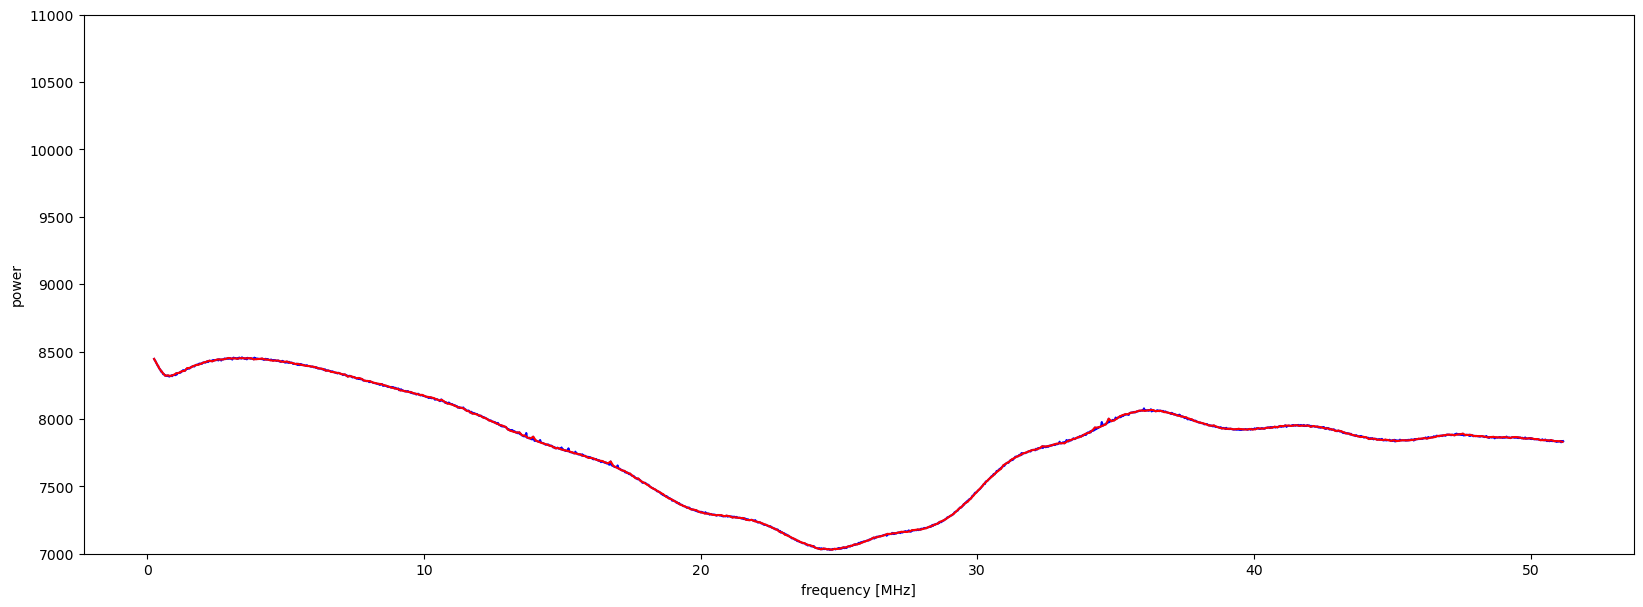

In [195]:

plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f[10:],s[10:],'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[10:2048:4],s[10:2048:4],'r-',markersize=3)

#plt.ylim(6e2,2e3)
#plt.xlim(38,52)
#plt.semilogy()
plt.ylim(7000,11e3)
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

Text(0, 0.5, 'power')

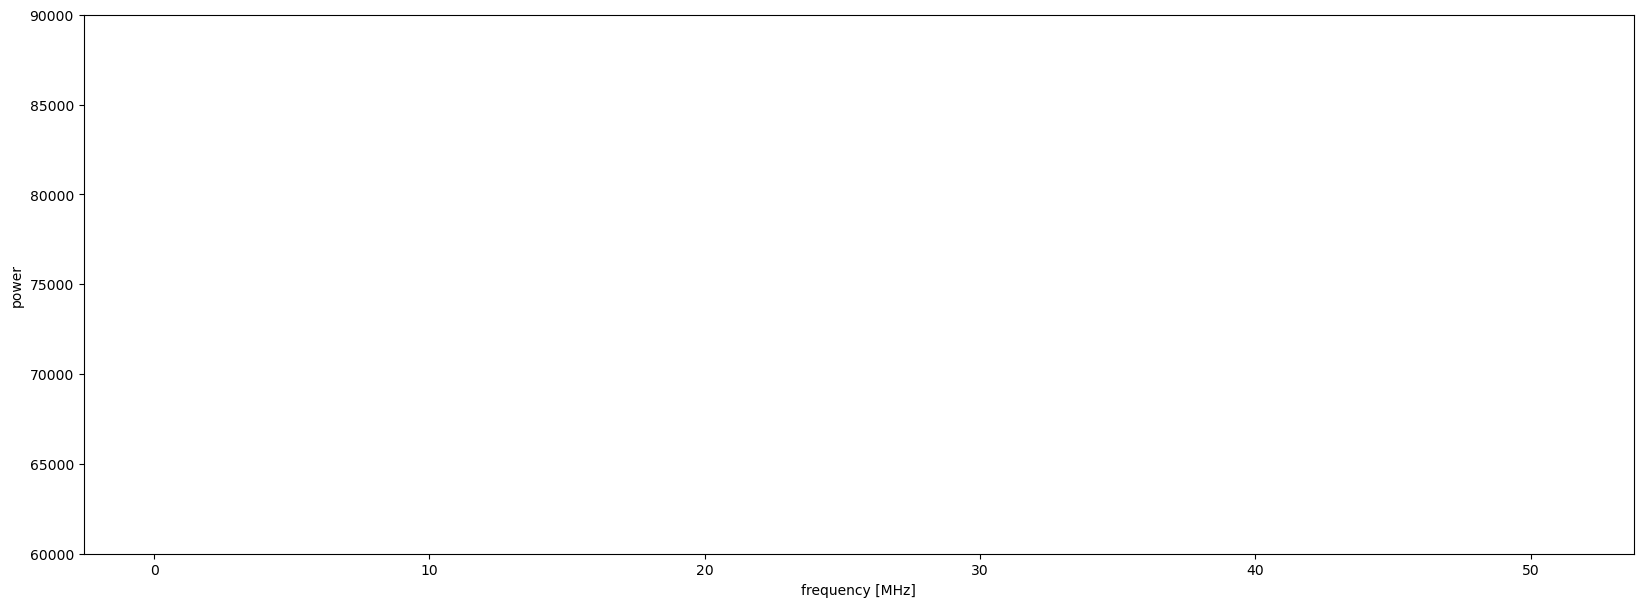

In [196]:
plt.figure(figsize=(20,7))
f = C.spectra[0][0].frequency
s = np.mean([sp[1].data[:] for sp in C.spectra],axis=0)
plt.plot(f,s,'b-')
#plt.plot(f,s*1.03,'k-')
plt.plot(f[2:2048:4],s[2:2048:4],'ro',markersize=3)

plt.ylim(60e3,90e3)



#plt.xlim(38,52)
#plt.semilogy()
plt.xlabel('frequency [MHz]')
plt.ylabel('power')

In [197]:
kcomb = np.arange(512)*4+2

def phase_up (first, second):
    """ Phases up second waveform to the first one """
    Nfft= len(first)*1024
    cross= first*np.conj(second)
    fi = np.zeros(Nfft,complex)
    fi[kcomb] = cross
    xi = np.real(np.fft.fft(fi))
    phi = xi.argmax()*2*np.pi/len(xi)
    second_phased = np.exp(+1j*phi*kcomb)*second
    return second_phased
    

In [198]:
_,wf = np.loadtxt("calibrator_231001.txt").T
wf = np.fft.rfft(np.hstack((wf,wf)))
wf = wf[2::4]

In [199]:


def coherent_addition (C):
    calib_data = []
    for ch in range(4):
        first = np.copy(C.calib_data[-1,ch,:])
        for second in C.calib_data[-1:1:-1,ch,:]:
            second_phased = phase_up(first,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data.append(first)
    calib_data = np.array(calib_data)
    calib_data_wf = []
    for ch in range(4):
        first = np.zeros(512,dtype=complex)
        for second in C.calib_data[1:,ch,:]:
            second_phased = phase_up(wf,second)
            first += second_phased
            #plt.plot(np.angle(first[20:]/second_phased[20:]))
            #plt.plot(second_phased[20:])
            #stop()
        calib_data_wf.append(first)
    calib_data_wf = np.array(calib_data_wf)
    return calib_data, calib_data_wf

calib_data, calib_data_wf = coherent_addition(C)
#calib_datad, calib_data_wfd = coherent_addition(Cd)


(0.0, 510.0)

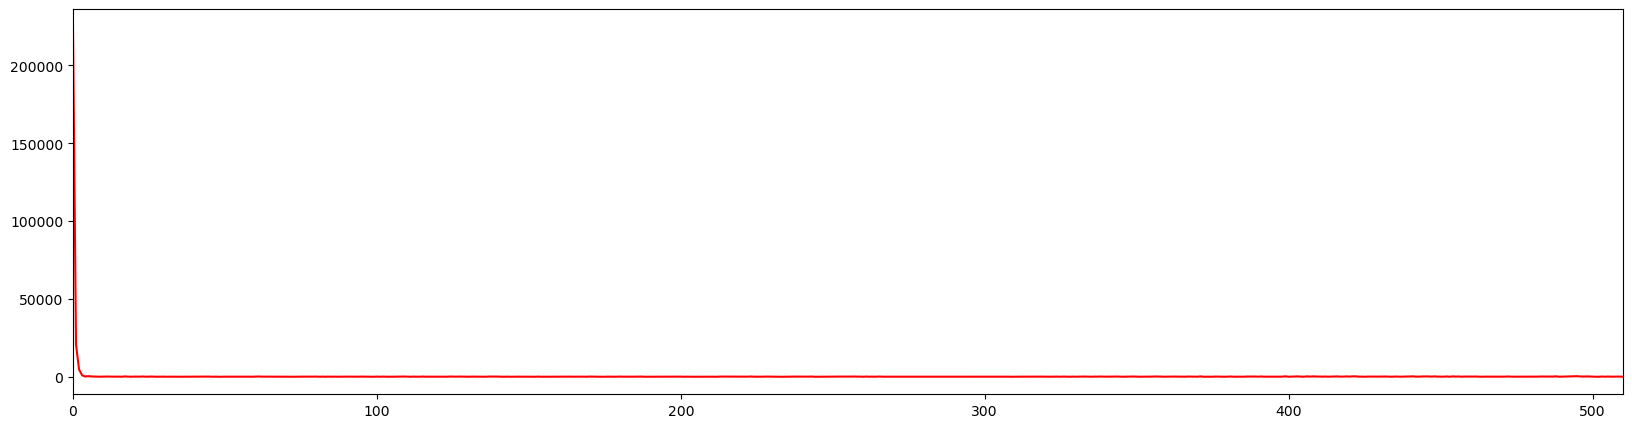

In [200]:
plt.figure(figsize=(20,5))
p1 = np.abs(calib_data[1,:])
#p2 = np.abs(calib_datad[3,30:])
            
#plt.plot((p1-p2)/p1)
#plt.ylim(-0.01,0.01)

#plt.plot(np.abs(calib_data_wf[1,:]),'b-')
plt.plot(np.abs(calib_data[0,:]),'r-')

plt.xlim(000,510)
#plt.plot(p2)


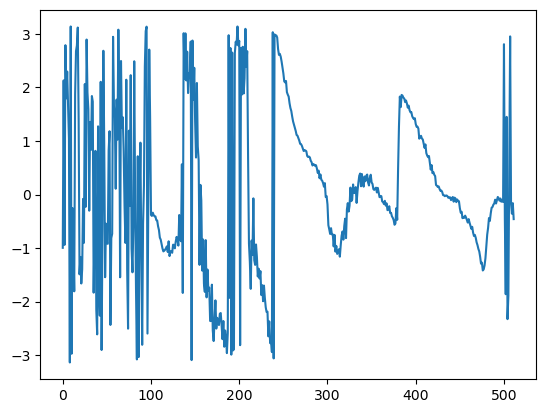

In [201]:
#plt.plot(np.abs(calib_data[2,30:]))
plt.plot(np.angle(calib_data_wf[2,:]*np.conj(calib_data_wf[3,:])))

[]

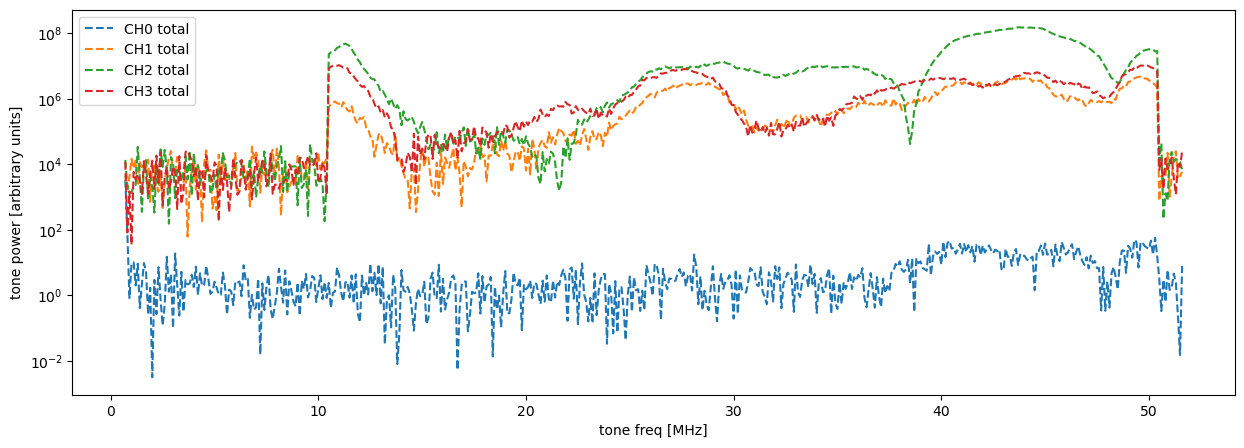

In [202]:
plt.figure(figsize=(15,5))
tfreq=0.5+0.1*np.arange(512)
for ch in [0,1,2,3]:#range(0,4):
    #plt.plot(tfreq[2:],np.abs(C.calib_data[1:,ch,2:]**2).mean(axis=0),label='CH'+str(ch)+" one int period")
    da = np.abs(calib_data_wf[ch,2:]**2)
    plt.plot(tfreq[2:],da/3000,ls='--',label='CH'+str(ch)+" total")
    #plt.plot(tfreq[2:],np.abs(Cd.calib_data[0:1,ch,2:]**2).mean(axis=0)*4,label='CH'+str(ch))
    #plt.plot(np.abs(Cx.calib_data[ch,1:,:]**1).mean(axis=0), label='CH'+str(ch))

    #plt.plot(np.abs(C.calib_data[ch,1:,100:500]**1).mean(axis=0)/np.abs(Cx.calib_data[ch,1:,100:500]**1).mean(axis=0), label='CH'+str(ch))


plt.legend()
plt.xlabel('tone freq [MHz]')
plt.ylabel('tone power [arbitrary units]')

#i1= np.real(C.calib_data[2,:,400])
#i2=np.imag(C.calib_data[2,:,400])
#i3= np.real(C.calib_data[3,:,400])
#plt.plot(np.imag(C.calib_data[3,:,100]))
#plt.plot(C.calib_data[0,:,400])
#plt.plot(r3**2+i3**2)

plt.semilogy()


In [203]:
#ch = 2
plt.figure(figsize=(20,5))
for i in range(4):
    s = np.mean([sp[ch].data[:] for sp in C.spectra],axis=0)[i::4]
    #c = np.abs(C.calib_data[:,ch,:]**2).mean(axis=0)
    fac = s[400]/c[400]*0.25
    
    plt.plot(s,'.')
    #plt.plot(c*fac,'.c-')
    plt.xlabel('frequency [MHz]')
    plt.ylabel('power [arbitrary units]')
    plt.semilogy()

KeyError: 3

<Figure size 2000x500 with 0 Axes>

In [204]:
np.abs(C.calib_data[1:,0,0:])


array([[5.58955114e+03, 5.35530578e+02, 1.22004098e+02, ...,
        3.60555128e+00, 1.36014705e+01, 1.86815417e+01],
       [5.50773601e+03, 5.25574923e+02, 1.14127122e+02, ...,
        1.00000000e+00, 9.05538514e+00, 5.00000000e+00],
       [5.55149646e+03, 5.14090459e+02, 1.40602276e+02, ...,
        1.30000000e+01, 1.11803399e+01, 4.00000000e+00],
       ...,
       [5.69217428e+03, 5.01327238e+02, 1.20283000e+02, ...,
        9.21954446e+00, 1.00498756e+01, 1.60312195e+01],
       [5.65571331e+03, 5.37033519e+02, 1.11973211e+02, ...,
        6.70820393e+00, 1.17046999e+01, 1.11803399e+01],
       [5.60534923e+03, 5.18787047e+02, 1.00767058e+02, ...,
        5.65685425e+00, 1.45602198e+01, 7.28010989e+00]], shape=(40, 512))

Text(0, 0.5, 'time index')

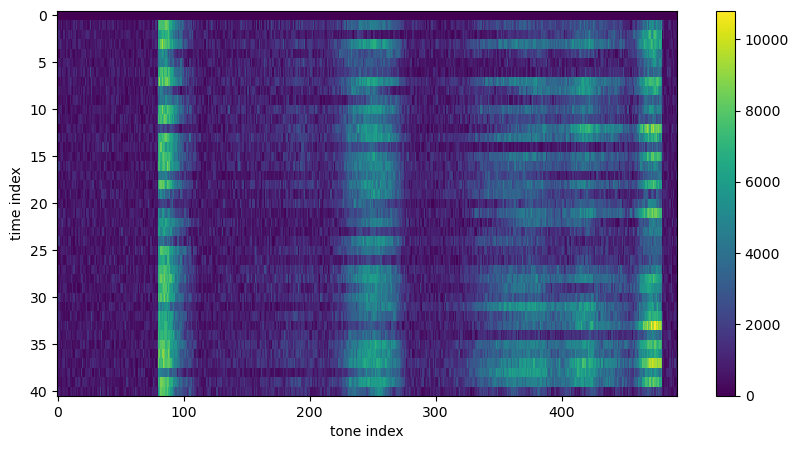

In [205]:
ch=3
plt.figure(figsize=(10,5))
plt.imshow(np.abs(C.calib_data[0:,ch,20:]),aspect='auto', interpolation='nearest')
plt.colorbar()
plt.xlabel('tone index')
plt.ylabel('time index')

Text(0.5, 0, 'time index')

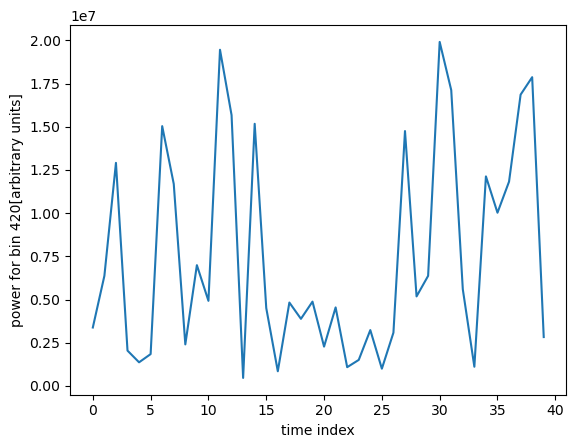

In [206]:
plt.plot(np.abs(C.calib_data[1:,ch,420]**2))
plt.ylabel('power for bin 420[arbitrary units]')
plt.xlabel('time index')

In [207]:
pcalib = phase_up(wf,calib_data_wf[2,:])
wf.shape, calib_data_wf[2,:].shape

((512,), (512,))

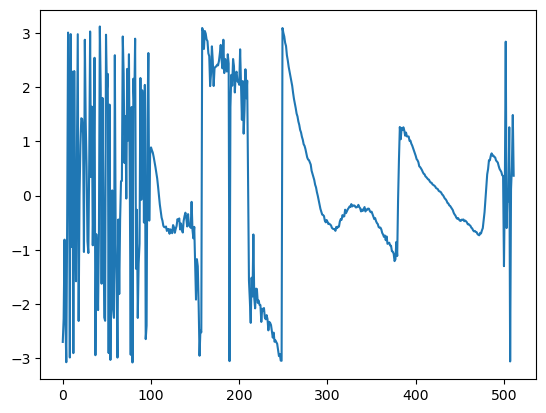

In [208]:
#plt.plot(np.angle(calib_data[1,:]/wf))
plt.plot(np.angle(pcalib/wf))

#plt.plot(np.imag(pcalib/wf))

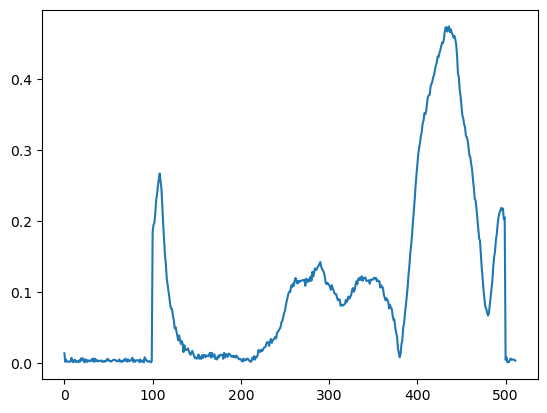

In [209]:
plt.plot(np.abs(pcalib/wf))

In [210]:
ch=2 
print (C.calib_data[15,ch,:].shape)
pcalib = phase_up(C.calib_data[15,ch,:], C.calib_data[25,ch,:])


(512,)


In [211]:
M = C.spectra[1]['meta']
M.base.actual_gain[:],M.base.gain[:], M.adc_max

([2, 2, 2, 2], [2, 2, 2, 2], array([-14, 266, 324, 301]))

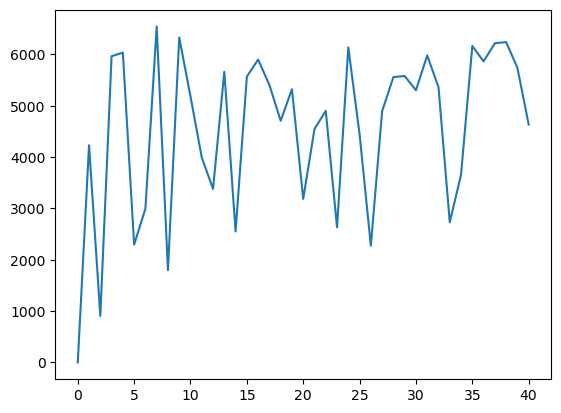

In [212]:
plt.plot(np.abs(C.calib_data[0:,ch,300]))